<a href="https://colab.research.google.com/github/harishkollana/Topic-Modeling-on-News-Articles-Clustering/blob/main/Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

# **Breakdown of this Notebook:**


1. **Importing Libraries**
2. **Loading the dataset**
3. **Dataset Information**
4. **Data Cleaning**
5. **Data Analysis On Columns:**
6. **Topic Modelling**
      1. **LSA - Latent Semantic Allocation**
      2. **LDA - Latent Dirichlet Allocation**
7. **Conclusion**


# **Import Libraries**

In [2]:
#import libraries for topic modeling on news articles
import numpy as np
import pandas as pd
import scipy.stats as stats
import json
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#spacy for lemmatization
import spacy
import glob
import string
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
!pip install pyLDAvis==3.2.1
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 1.7 MB 8.5 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=f7bf7883ba887667b6c0951255c1f14a1f646b610c75c691bf061877448571b6
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
!pip install spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=136688758acaa90b0f02aa45b0757695cb2dbfb3a61ddd2f4ba349eef7c2109f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ottcurla/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
from collections import Counter

# **Loading Dataset**

In [5]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#load path to data
path = '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc'

In [7]:
News=[]
Type=[]
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News,'type':Type}
df = pd.DataFrame(data)

# **Dataset Information**

In [8]:
#checking df
df.head()

,news,type
0,b'UK economy ends year with spurt\n\nThe UK ec...,business
1,"b""China now top trader with Japan\n\nChina ove...",business
2,b'Tsunami slows Sri Lanka\'s growth\n\nSri Lan...,business
3,"b""Millions go missing at China bank\n\nTwo sen...",business
4,"b""Lacroix label bought by US firm\n\nLuxury go...",business


In [9]:
#checking info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [10]:
#finding no of articles w.r.t to topics
df['type'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

In [11]:
#finding duplicates
df.duplicated().sum()

98

# **Data Cleaning**

In [12]:
# removing duplicate observations
df=df.drop_duplicates()

In [13]:
df.type.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

In [14]:
# Converting column into astring
df['news'] = df['news'].astype('str') 

In [16]:
import re

In [17]:
# Remove new line characters
df['news'] = [re.sub('\s+', ' ', sent) for sent in df['news']]

#convert to lowercase
df['news'] = df['news'].map(lambda x: x.lower())

# Remove distracting single quotes
df['news'] = [re.sub("\'", "", sent) for sent in df['news']]

#Removal of stopwords
df['news'] = df['news'].map(lambda x: ' '.join([i for i in x.split(' ') if i not in stopwords.words('english')]))

pprint(df[:1])

                                                news      type
0  buk economy ends year spurt\n\nthe uk economy ...  business


In [18]:
# Doing Lemmatization
def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [19]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

In [20]:
#check data
df.head()

,news,type
0,economy end year economy grow estimate % accel...,business
1,top trader overtake become big trading partner...,business
2,slow launch reconstruction drive worth appeal ...,business
3,"b""million go miss senior official china top co...",business
4,buy good group lvmh sell loss make christian l...,business


# **Explorative Data Analysis**

## **Type Of news Counts**

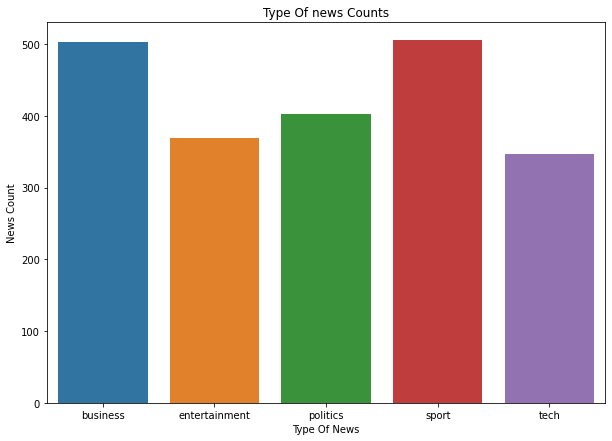

In [21]:
#set figure size
plt.rcParams['figure.figsize'] = [10, 7]

#create a countplot for type in df
sns.countplot(x='type', data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

In [22]:
df['length']=df['news'].apply(len)
df.head()

,news,type,length
0,economy end year economy grow estimate % accel...,business,1520
1,top trader overtake become big trading partner...,business,686
2,slow launch reconstruction drive worth appeal ...,business,1555
3,"b""million go miss senior official china top co...",business,1616
4,buy good group lvmh sell loss make christian l...,business,446


In [23]:
df['word_count'] = df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

,news,type,length,word_count
0,economy end year economy grow estimate % accel...,business,1520,215
1,top trader overtake become big trading partner...,business,686,108
2,slow launch reconstruction drive worth appeal ...,business,1555,218
3,"b""million go miss senior official china top co...",business,1616,223
4,buy good group lvmh sell loss make christian l...,business,446,72


In [24]:
bbc1_business = df[df['type'] == 'business']
bbc1_entertainment = df[df['type'] == 'entertainment']
bbc1_politics = df[df['type'] == 'politics']
bbc1_sport = df[df['type'] == 'sport']
bbc1_tech = df[df['type'] == 'tech']

## **Get top words**

In [25]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

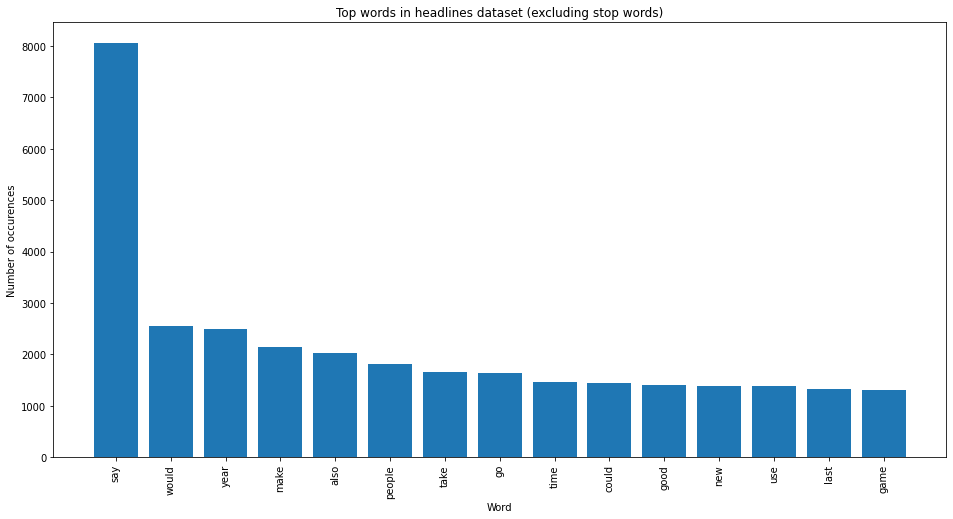

In [26]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

## **Length of News**

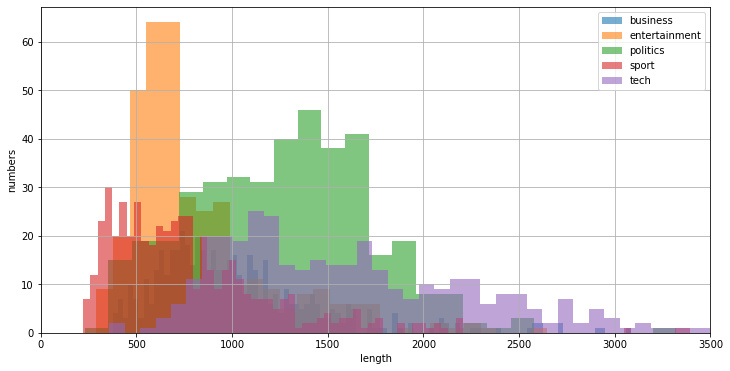

In [27]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,3500)
plt.grid()
plt.show()

Length of all type of topics are dense between 1500-2000.

## **Number of Words**

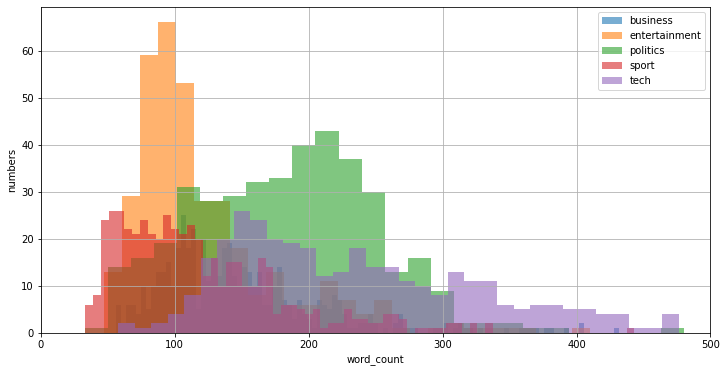

In [28]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

It's similar to length

## **Type Column : business**

In [30]:
from wordcloud import WordCloud

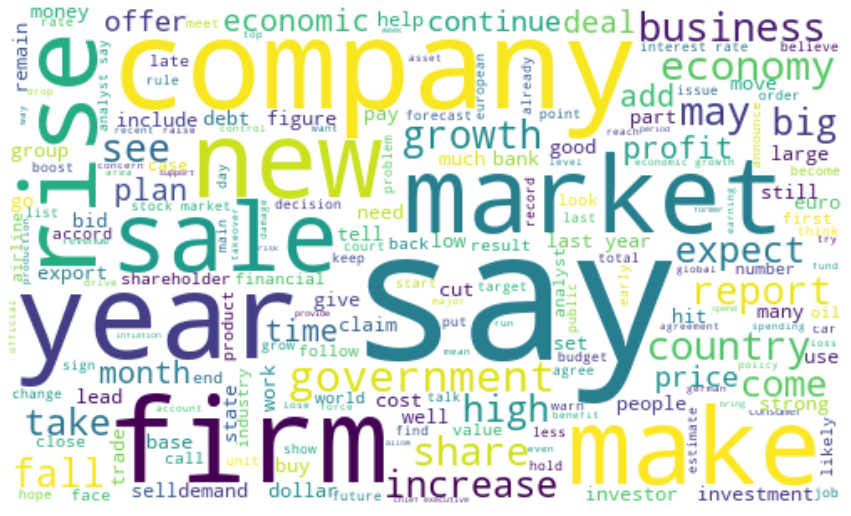

In [31]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Type Column : entertainment**

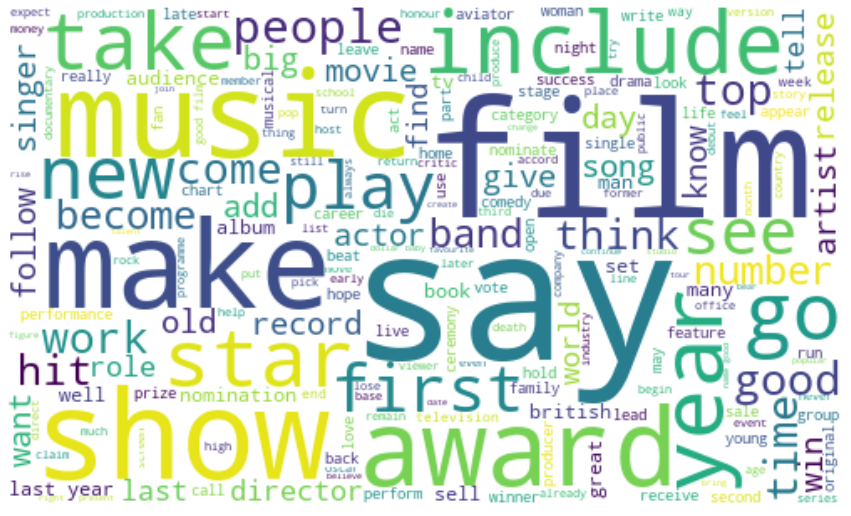

In [32]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='entertainment']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Type Column : sport**

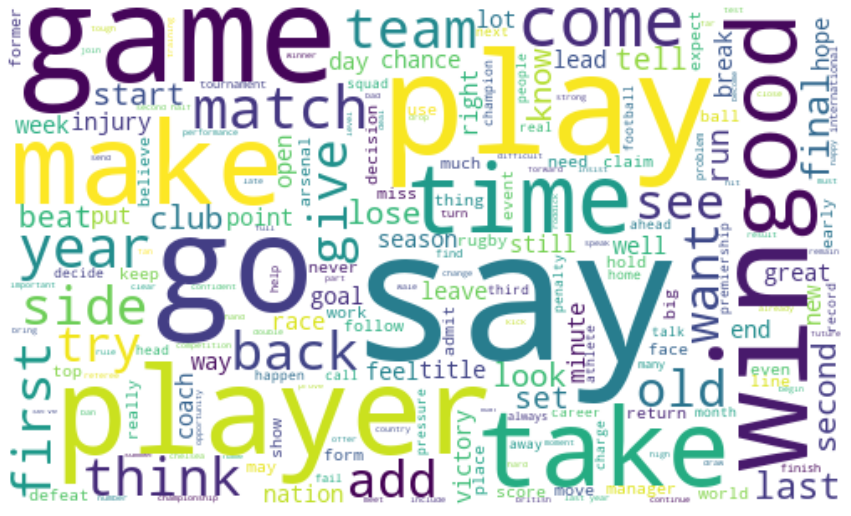

In [33]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Type Column : politics**

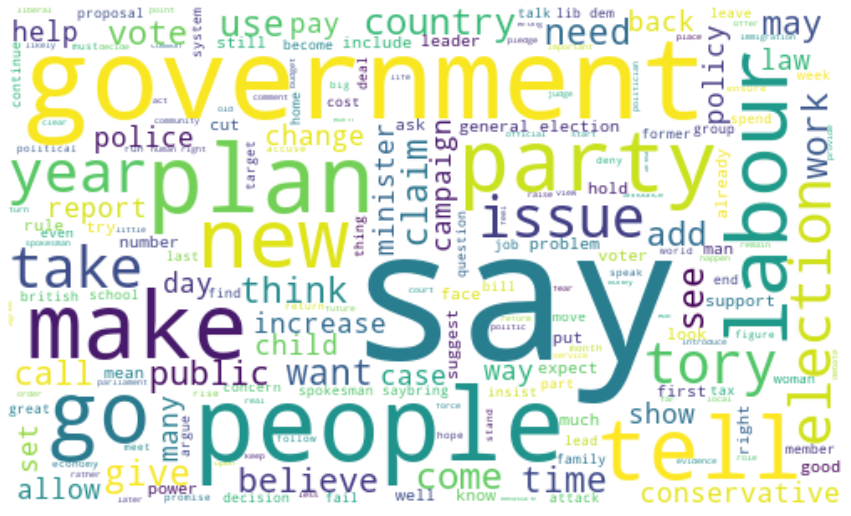

In [34]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='politics']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Type Column : tech**

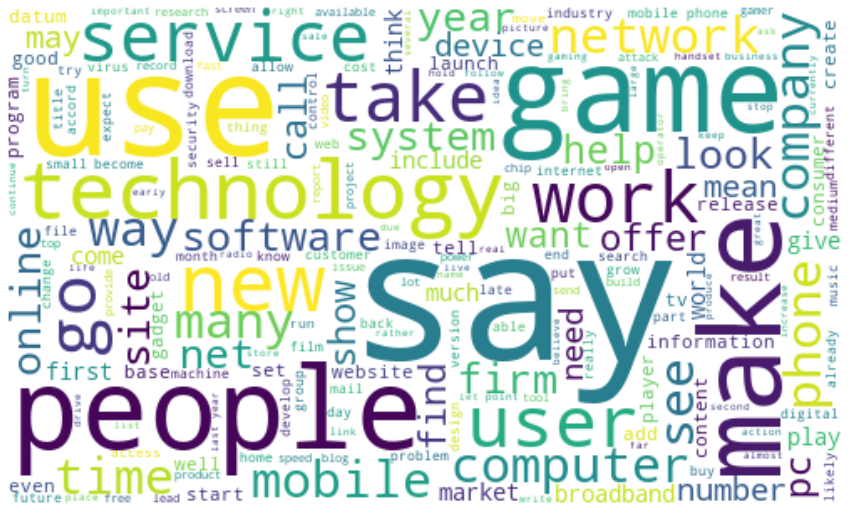

In [35]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='tech']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **Topic Modelling**

1. LSA - Latent Semantic Allocation

2. LDA - Latent Dirichlet Allocation

## **LSA - Latent Semantic Allocation**

In [36]:
lsa_df = pd.DataFrame({'Heading' : df['type'],'News': df['news']})

In [37]:
lsa_df.head()

,Heading,News
0,business,economy end year economy grow estimate % accel...
1,business,top trader overtake become big trading partner...
2,business,slow launch reconstruction drive worth appeal ...
3,business,"b""million go miss senior official china top co..."
4,business,buy good group lvmh sell loss make christian l...


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

In [39]:
stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+", 
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(lsa_df['News'])
dtm_mat = dtm.transform(lsa_df['News'])

In [40]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)

In [41]:
s_list = []

for clus in tqdm(range(2,21)):

    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)

    s_list.append(s)

100%|██████████| 19/19 [01:58<00:00,  6.23s/it]


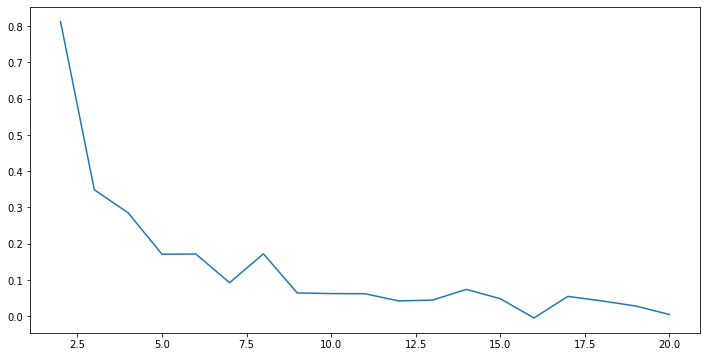

In [42]:
plt.plot(range(2,21), s_list)

plt.show()

From the above graph we can clearly see that topic number=4 has the highest coherence score.

In [43]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


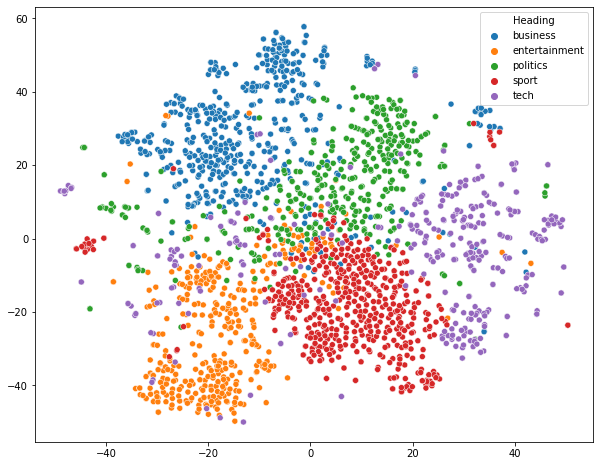

In [44]:
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=lsa_df['Heading'])

In this plot, only the tech-related news article looks like having a much wider spread whereas other news articles look quite nicely clustered. 

## **LDA - Latent Dirichlet Allocation**

TF-IDF Vectorizer with unigram

In [45]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000,min_df=0.05)

In [46]:
matrix=vectorizer.fit_transform(df['news'])

In [47]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
model=LatentDirichletAllocation(n_components=5)
lda_topic_matrix=model.fit_transform(matrix)

In [49]:
doc = pd.DataFrame(model.transform(matrix))

In [50]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

In [51]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [52]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [53]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2127 samples in 0.004s...
[t-SNE] Computed neighbors for 2127 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2127
[t-SNE] Computed conditional probabilities for sample 2000 / 2127
[t-SNE] Computed conditional probabilities for sample 2127 / 2127
[t-SNE] Mean sigma: 0.003321
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.896706
[t-SNE] KL divergence after 2000 iterations: 0.214493


In [54]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()


In [55]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  33.421493
1       51.163364 -159.968018       2        1  23.566938
0      -73.144554   21.523815       3        1  21.523565
3      -66.410133 -110.606438       4        1  17.708925
4       54.417324   12.443444       5        1   3.779079, topic_info=          Term       Freq      Total Category  logprob  loglift
73      charge  37.000000  37.000000  Default  30.0000  30.0000
463       test  32.000000  32.000000  Default  29.0000  29.0000
102      court  32.000000  32.000000  Default  28.0000  28.0000
477      trial  27.000000  27.000000  Default  27.0000  27.0000
67        case  33.000000  33.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
312   official   2.649422  23.910927   Topic5  -5.2203   1.0757
188       give   3.251160  48.090035   Topic5  -5.0157   0.5816
435  spokesman   2.627867  27.132501   Topic5  -5.2285   0.9411
455       take   3.141493  72.147486   Topic5  -5.0500   0.1417
19        also   2.893488  79.886394   Topic5  -5.1322  -0.0425

[249 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         2  0.229686  access
2         3  0.114843  access
2         4  0.631637  access
5         1  0.102700  accuse
5         2  0.462151  accuse
...     ...       ...     ...
508       1  0.354090    year
508       2  0.145802    year
508       3  0.364504    year
508       4  0.114558    year
508       5  0.020829    year

[721 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])

Controlling for t -SNE, it would seem that LDA has had much more succcess than LSA

# **Conclusion**

In this Notebook we had analyzed the BBC articles using LDA and LSA Topic modelling techniques and found lsa seems more impactful on segregation of topics.

In future we can use one of model to predict the user input of text query to type of news. We can recommend news articles to the users by following these methods.